In [10]:
import random
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from collections import Counter
import time
import os
import pandas as pd
from scipy.signal import correlate
import matplotlib.pyplot as plt
import sys
import colorsys

In [11]:
def create_palette(num_labels=1000):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')
    
    # Existing colors represented as hexadecimal strings
    existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

    return np.concatenate([existing_colors, colors])

palette = create_palette()

In [20]:
def plot_raster(params, A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse):
    import matplotlib.ticker as ticker
    N, M, D, T, seed, num_SM_events, SM_total_spikes, noise = params['N'], params['M'], params['D'], params['T'], params['seed'],params['num_SM_events'],params['SM_total_spikes'],params['noise']  

    fig, ax = plt.subplot_mosaic('AB;CD;EE;FF;GG', figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

    s = 1

    palette = create_palette()

    # Scatter plots for A, B, C, D
    for i, k in enumerate(['A', 'B', 'C', 'D']):
        ax[k].scatter(K_sparse[1][K_sparse[2] == i+1], K_sparse[0][K_sparse[2] == i+1], c=palette[i+1], s=s)
        ax[k].set_title(f'Spiking Motif {i + 1}')  # Updated title for plots A, B, C, D
        ax[k].set_xlabel('Time Steps')
        ax[k].set_ylabel('Neurons')
        ax[k].set_yticks(range(1, N))

    spiking_motif_data = [B_sparse[0][B_sparse[1] == i+1] for i in range(4)]  # Collect data for each Spiking Motif
    ax['E'].scatter(B_sparse[1], B_sparse[0]-1, c=palette[B_sparse[0]], s=s)
    ax['E'].set_title('Occurrences of each Spiking Motif randomly assigned')
    ax['E'].set_xlabel('Time Steps')
    ax['E'].set_ylabel('Spiking Motif')  # Updated y-axis label for plot E

    # Set y-axis ticks and labels explicitly for Spiking Motifs 1 to 4
    ax['E'].set_yticks(range(0, M))  # Set y-axis ticks for plot E to represent the four Spiking Motifs
    ax['E'].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x) + 1}'))  # Map y-axis labels to display 1 through 4
    ax['E'].set_ylim(-0.5, 3.5)  # Set y-axis limits to display only the ticks and labels for the existing values


    # Scatter plot for F
    ax['F'].scatter(A_sparse[1], A_sparse[0], c=palette[A_sparse[2]], alpha=0.9, s=s*4, marker='.')
    ax['F'].set_title('Resulting raster plot')
    ax['F'].set_xlabel('Time Steps')
    ax['F'].set_ylabel('Neurons')  # Y-axis represents neurons, no need to update y-axis label
    ax['F'].set_yticks(range(1, N))  # Set y-axis ticks for plot F to represent neurons

    sanity_check = np.zeros((T,M))
    for j in range(M):
        for i in range(T-D):
            sanity_check[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
        sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

    # Plot for G
    [ax['G'].plot(sanity_check[:, i], color=palette[i+1], alpha=0.4) for i in range(M)]
    ax['G'].set_title('Result of Convolution of Spiking Motifs across the raster plot')
    ax['G'].set_xlabel('Time Steps')
    ax['G'].set_ylabel('Correlation Coefficient')  # Updated y-axis label for plot G
    ax['G'].set_yticks([])  # Remove y-axis ticks for plot G

    # Set common x-axis from 0 to 1000 with padding
    common_xlim = (min(A_sparse[1]), max(A_sparse[1]))
    padding = 10
    ax['E'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
    ax['F'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
    ax['G'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)

    # Share x-axis for E, F, and G
    ax['E'].sharex(ax['F'])
    ax['G'].sharex(ax['F'])

    # Hide x-axis ticks and labels for E and F
    ax['E'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax['F'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    plt.show()

In [21]:
def generate_synthetic_data(params, plot=False):
    '''
    Synthetic Data Generation
    '''
    # Dense K: matrix of binary images of sizeNxDxM
    # Sparse K: set of (delay d, neuron a, and pg b)
    N, M, D, T, seed, num_SM_events, SM_total_spikes, noise = params['N'], params['M'], params['D'], params['T'], params['seed'],params['num_SM_events'],params['SM_total_spikes'],params['noise']

    # Loop through each 'M' dimension
    K_rand = np.random.rand(N,D,M)
    K_dense = np.zeros_like(K_rand)

    B_rand = np.random.rand(M,T-D)
    B_dense = np.zeros_like(B_rand) 

    A_dense = np.zeros((N,T,M+1))
    A_rand = np.random.rand(N,T)
    sorted_indices_A = np.argsort(A_rand[:,:],axis=None)
    top_indices_A = np.unravel_index(sorted_indices_A[-noise:], (N, T))
    A_dense[top_indices_A[0], top_indices_A[1], 0] =1

    for m in range(M):
        # Sort the current 'M' dimension
        sorted_indices_K = np.argsort(K_rand[:, :, m], axis=None)
        sorted_indices_B = np.argsort(B_rand[m, :], axis=None)

        # Find the indices of the 'X' highest values in this dimension
        top_indices_K = np.unravel_index(sorted_indices_K[-SM_total_spikes:], (N, D))
        top_indices_B = np.unravel_index(sorted_indices_B[-num_SM_events:], (T))

        # Set the corresponding elements to 1 in the binary matrix
        K_dense[top_indices_K[0], top_indices_K[1], m] = 1
        B_dense[m, top_indices_B[0]] = 1

    K_sparse = np.where(K_dense)
    B_sparse = np.where(B_dense)
    K_sparse = np.array((K_sparse[0], K_sparse[1], K_sparse[2]+1))
    B_sparse = np.array((B_sparse[0]+1, B_sparse[1]))

    for i in range(len(B_sparse[0])):
        t = B_sparse[1][i]
        b = B_sparse[0][i]
        A_dense[:, t:t+D, b] += K_dense[...,b-1]
    A_sparse = np.where(A_dense)
    A_dense = np.sum(A_dense,axis=2)
    A_dense[A_dense>1] = 1

    if plot:
        plot_raster(params, A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse)
    
    return A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse

In [24]:
N = 1000
M = 10
D = 71
T = 1000
seed=0

num_SM_events = 10
SM_total_spikes = 15
noise = 500

params = {
    'N':N,
    'M':M,
    'D':D,
    'T':T,
    'seed':seed,
    'num_SM_events':num_SM_events,
    'SM_total_spikes':SM_total_spikes,
    'noise':noise
}

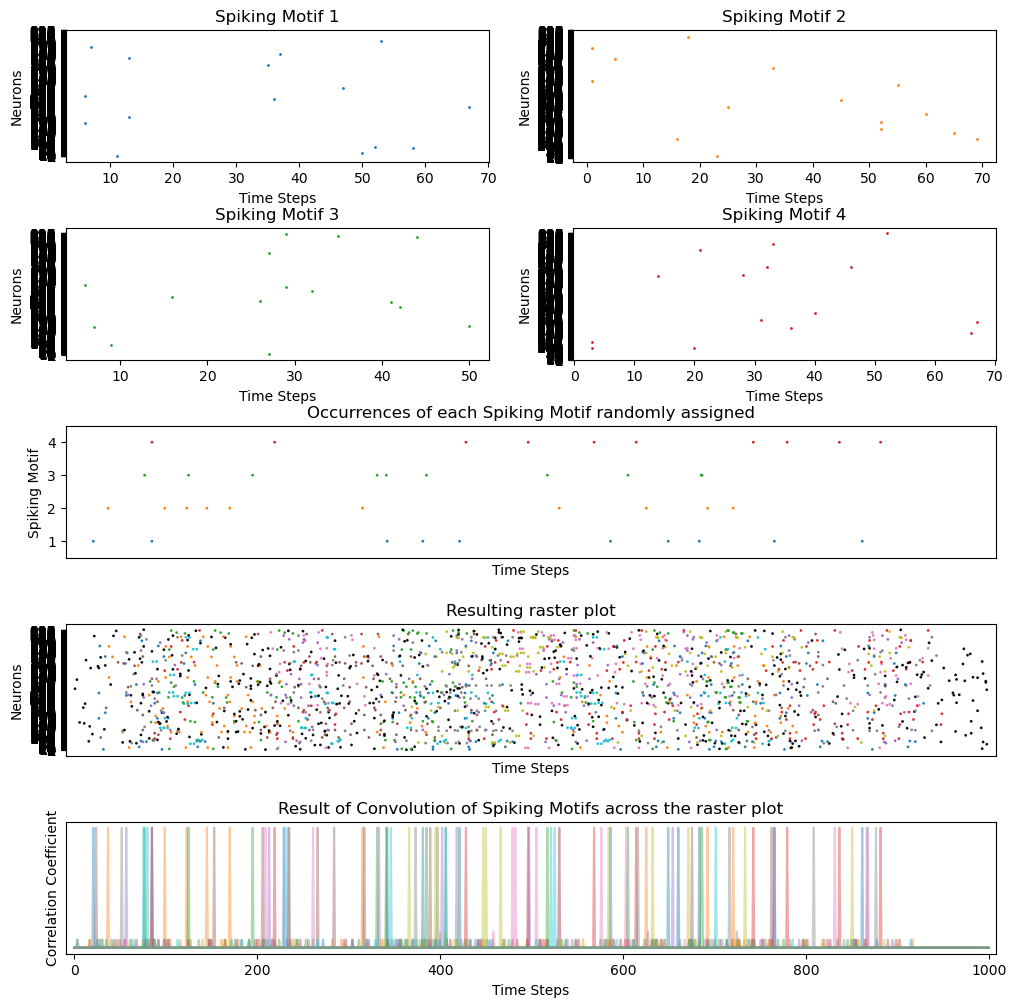

In [25]:
A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse = generate_synthetic_data(params, plot=True)

# Script form

In [1]:
import simulate_data

In [2]:
N = 100
M = 4
D = 71
T = 1000
seed=0

num_SM_events = 5
SM_total_spikes = 10
noise = 50

params = {
    'N':N,
    'M':M,
    'D':D,
    'T':T,
    'seed':seed,
    'num_SM_events':num_SM_events,
    'SM_total_spikes':SM_total_spikes,
    'noise':noise
}

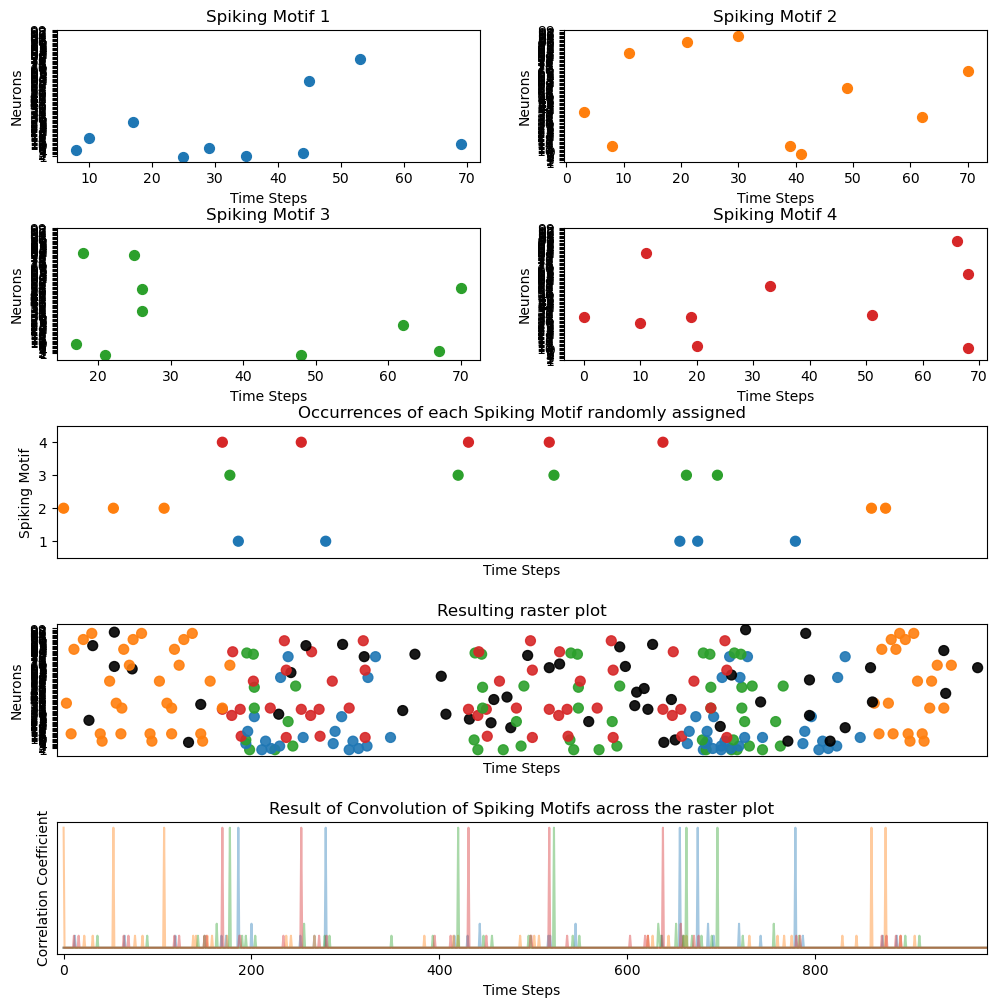

In [3]:
A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse = simulate_data.generate_synthetic_data(params, plot=True)